In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#tradeable

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])
#asset_info_df.sort_values("symbol", inplace=True)

# Display the first 10 asset tickers
asset_info_df.head(10)

,symbol
0,ABEV
1,BZUN
2,NEM
3,MA
4,NET
5,V
6,DLTR
7,WMT
8,HUYA
9,CCXI


In [5]:
# Set the ticker
ticker = input("Enter the ticker to run the Monte Carlo Simulation")

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-03-20", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-03-20", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for the desired stock
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.tail()

Enter the ticker to run the Monte Carlo Simulation RBC


RBC                               
                            open   high      low  close  volume
2020-03-16 00:00:00-04:00  59.01  63.96  59.0100  61.10  620330
2020-03-17 00:00:00-04:00  62.14  69.51  60.2200  68.75  714140
2020-03-18 00:00:00-04:00  64.52  66.73  55.8311  57.43  544352
2020-03-19 00:00:00-04:00  56.90  59.80  55.2200  59.12  676528
2020-03-20 00:00:00-04:00  59.70  63.27  57.4800  57.65  776882

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)


# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-03-16,61.10
2020-03-17,68.75
2020-03-18,57.43
2020-03-19,59.12
2020-03-20,57.65


In [7]:
# Use the `pct_change` function to calculate daily returns of BB
daily_returns = df.pct_change()

# Use the `mean` function to calculate the mean of daily returns for BB
avg_daily_return = daily_returns.mean()["close"]

# Use the `std` function to calculate the standard deviation of daily returns for BB
std_dev_daily_return = daily_returns.std()["close"]

In [8]:
# Set number of trading days and get last closing price of stoock from DataFrame
num_simulations = 1000
num_trading_days = 81 
stock_last_price = df["close"][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_ticker_prices = [stock_last_price]

        # Simulate the returns for 81  trading days (till 20th july 2020)
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_ticker_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_ticker_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_ticker_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,...,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000,57.650000
1,58.972463,59.415066,58.105722,58.568477,58.224279,57.612937,56.688416,58.644770,57.975067,55.978613,...,57.166238,59.865069,58.379142,57.211282,57.733923,56.212627,57.764675,59.273304,55.371897,58.710228
2,57.161362,60.348067,56.792575,60.374369,56.069027,58.651791,53.863697,55.029208,57.341749,55.899497,...,57.164822,63.422553,55.469001,56.591744,59.033573,56.778306,59.246363,59.496959,56.247883,58.573986
3,55.481864,60.337518,55.518612,60.425325,56.105951,59.186840,52.260240,55.569048,56.795613,57.931006,...,58.433175,63.127550,54.981130,57.044839,58.651185,55.270833,57.423548,55.783553,53.881833,56.864872
4,57.007520,59.213338,57.072928,59.979165,57.739804,60.355863,53.467790,56.401403,56.486577,59.885638,...,59.667625,62.379338,52.667359,55.662100,58.466333,52.686487,55.608893,54.614895,55.705396,57.530393


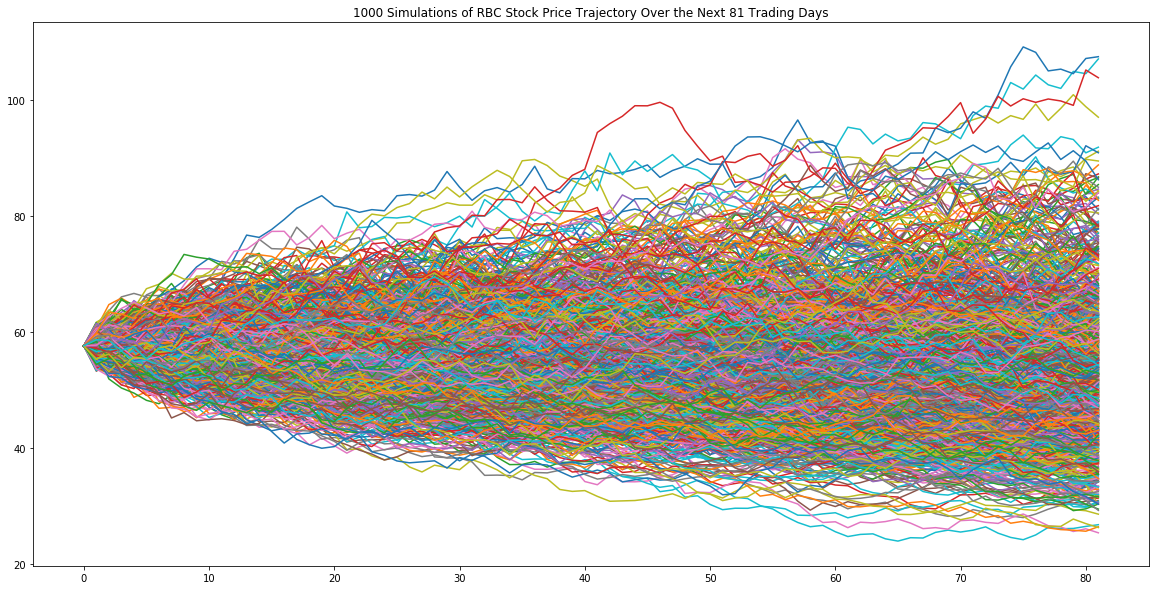

In [9]:
# Use the `plot` function to plot the trajectory of given stock based on a 81 trading day simulation
plot_title = f"{n+1} Simulations of {ticker} Stock Price Trajectory Over the Next 81 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title, figsize =[20,10])

In [10]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    46.845862
Simulation 2    69.924203
Simulation 3    48.112822
Simulation 4    55.194773
Simulation 5    35.036852
Name: 81, dtype: float64

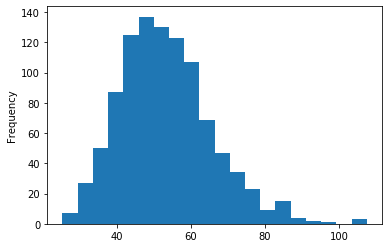

In [11]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

In [12]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(45.93, 50.037]       0.137
(50.037, 54.144]      0.130
(41.824, 45.93]       0.125
(54.144, 58.25]       0.123
(58.25, 62.357]       0.107
(37.717, 41.824]      0.087
(62.357, 66.464]      0.069
(33.61, 37.717]       0.050
(66.464, 70.57]       0.047
(70.57, 74.677]       0.034
(29.504, 33.61]       0.027
(74.677, 78.784]      0.023
(82.89, 86.997]       0.015
(78.784, 82.89]       0.009
(25.314, 29.504]      0.007
(86.997, 91.104]      0.004
(103.424, 107.531]    0.003
(91.104, 95.21]       0.002
(95.21, 99.317]       0.001
(99.317, 103.424]     0.000
Name: 81, dtype: float64

In [13]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    32.645473
0.975    82.750988
Name: 81, dtype: float64

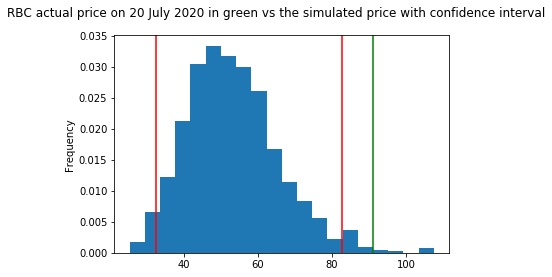

In [14]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

#Plot the actual price on 20th July of the stock

# Set timeframe to "1D"
timeframe = "1D"

# Set the dates for the price of the desired stock for 20 July 2020
start_date = pd.Timestamp("2020-07-19", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-07-20", tz="America/New_York").isoformat()

# Get actual stock price for the desired stock on 20th July 2020
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
    ).df

title_plot = (f"{ticker} actual price on 20 July 2020 in green vs the simulated price with confidence interval")
plt.suptitle(title_plot)
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


actual_price = df["close"]

plt.axvline(actual_price.iloc[0], color='g')
